In [101]:
# Librerías
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, recall_score

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,confusion_matrix, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

import time

In [5]:
# Carga de datos
# Definir las rutas completas (¡Pega la ruta que copiaste!)
path_x_train = '../../../data/x_train.csv' # PASTE YOUR CORRECT PATH HERE
path_y_train = '../../../data/y_train.csv' # PASTE YOUR CORRECT PATH HERE
path_x_test = '../../../data/x_test.csv'   # PASTE YOUR CORRECT PATH HERE
path_y_test = '../../../data/y_test.csv'

# Cargar los datos
x_train = pd.read_csv(path_x_train).copy()
y_train = pd.read_csv(path_y_train).copy()
x_test = pd.read_csv(path_x_test).copy()
y_test = pd.read_csv(path_y_test).copy()


### Correcting Data Paths

Please update the `path_x_train`, `path_y_train`, `path_x_test`, and `path_y_test` variables below with the correct paths to your CSV files in Google Drive. You can find these paths by navigating your Google Drive files in the Colab file browser (folder icon on the left sidebar), right-clicking on each file, and selecting 'Copy path'.

Creamos una función que crea modelos

In [ ]:
def rf_crear_modelo(param_grid,scoring,cv):
        modelo = GridSearchCV(
            estimator = RandomForestClassifier(random_state=42, n_jobs= -1),
            param_grid=param_grid,
            scoring=scoring,
            cv = cv,
            n_jobs=-1,
            verbose= 1
        )
        return modelo

Creamos otra función para crear grid_search

In [7]:
def param_grid_genrator(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    param_grid_rf = {
        "n_estimators": n_estimators,
        "criterion": ["gini"],
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf
    }
    return param_grid_rf

In [105]:

# Archivo donde se guardarán las métricas
from pathlib import Path
ARCHIVO_METRICAS = Path("metrics_random_forest.csv")


# Columnas estándar
COLUMNAS = [
    "modelo", "experimento", "accuracy_train", "accuracy_test",
    "recall_train_avg", "recall_test_avg", "f1_train_avg","f1_test_avg" "tiempo_entrenamiento_seg", "overfitting", "observaciones"
]



def calcular_metricas(modelo, x_train,y_train,x_test,y_test):


    """
    Calcula y muestra las métricas principales de un modelo de clasificación multiclase.


    Parámetros:
    -----------
    modelo : objeto entrenado
        Modelo de clasificación ya entrenado (por ejemplo, DecisionTreeClassifier, RandomForestClassifier, etc.).
    x_train : array-like o DataFrame
        Datos de entrenamiento.
    y_train : array-like
        Etiquetas verdaderas del conjunto de entrenamiento.
    x_test : array-like o DataFrame
        Datos de prueba.
    y_test : array-like
        Etiquetas verdaderas del conjunto de prueba.


    Métricas calculadas e impresas:
    -------------------------------
    - Accuracy en entrenamiento
    - Accuracy en test
    - Recall en entrenamiento (promedio ponderado)
    - Recall en test (promedio ponderado)
    - F1-score en entrenamiento (promedio ponderado)
    - F1-score en test (promedio ponderado)


    Retorna:
    --------
    Tuple de 6 floats:
        (accuracy_train, accuracy_test, recall_train, recall_test, f1_train, f1_test)


    Ejemplo de uso:
    ----------------
    acc_train, acc_test, rec_train, rec_test, f1_train, f1_test = calcular_metricas(
        modelo_base, x_train, y_train, x_test, y_test
    )
    """
    #Predicciones
    y_pred_train = modelo.predict(x_train)
    y_pred_test = modelo.predict(x_test)


    #Calcular las metricas


    # Accuracy en entrenamiento
    accuracy_train = accuracy_score(y_train, y_pred_train)
    # Accuracy en test
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # Recall en entrenamiento
    recall_train = recall_score(y_train, y_pred_train,average='macro')
    # Recall en test
    recall_test = recall_score(y_test, y_pred_test, average='macro')
    # F1-score en entrenamiento (balance entre precisión y recall)
    f1_train = f1_score(y_train, y_pred_train, average='macro')
    # F1-score en test
    f1_test = f1_score(y_test, y_pred_test, average='macro')
   
    print("="*60)
    print("TRAIN")
    print("="*60)
    print(f"Accuracy (train): {accuracy_train:.4f}")
    print(f"Recall (train): {recall_train:.4f}")
    print(f"F1-score (train): {f1_train:.4f}")
    print("="*60)
    print("TEST")
    print("="*60)
    print(f"Accuracy (test): {accuracy_test:.4f}")
    print(f"Recall (test): {recall_test:.4f}")
    print(f"F1-score (test): {f1_test:.4f}")


    return accuracy_train,accuracy_test,recall_train,recall_test,f1_train,f1_test

In [107]:
def agregar_metrica(modelo, experimento, accuracy_train, accuracy_test,
                    recall_train, recall_test, f1_train, f1_test,
                    tiempo_entrenamiento_seg, overfitting, observaciones,
                    archivo=ARCHIVO_METRICAS):
    """
    Agrega o actualiza las métricas de un modelo de clasificación en un archivo CSV.


    Si el archivo no existe, lo crea con las columnas estándar.


    Parámetros:
    -----------
    modelo : str
        Nombre del modelo.
    experimento : str
        Nombre o identificador del experimento.
    accuracy_train : float
        Accuracy en datos de entrenamiento.
    accuracy_test : float
        Accuracy en datos de prueba.
    recall_train : float
        Recall en entrenamiento.
    recall_test : float
        Recall en test.
    f1_train : float
        F1-score en entrenamiento.
    f1_test : float
        F1-score en test.
    tiempo_entrenamiento_seg : float
        Tiempo de entrenamiento (segundos).
    overfitting : str
        Indica sobreajuste ("Sí" o "No").
    observaciones : str
        Comentarios adicionales.
    archivo : str o Path, opcional
        Ruta del archivo CSV donde se guardarán las métricas.


    Retorna:
    --------
    None
    """


    # Crear DataFrame de la nueva fila
    nueva_fila = pd.DataFrame([{
        "modelo": modelo,
        "experimento": experimento,
        "accuracy_train": accuracy_train,
        "accuracy_test": accuracy_test,
        "recall_train_avg": recall_train,
        "recall_test_avg": recall_test,
        "f1_train_avg": f1_train,
        "f1_test_avg": f1_test,
        "tiempo_entrenamiento_seg": tiempo_entrenamiento_seg,
        "overfitting": overfitting,
        "observaciones": observaciones
    }])


    # Si el archivo existe, cargarlo
    if archivo.exists():
        df = pd.read_csv(archivo)
       
        # Si el experimento ya existe, reemplazar la fila
        if experimento in df['experimento'].values:
            df.loc[df['experimento'] == experimento] = nueva_fila.iloc[0]
            print(f"El experimento '{experimento}' existía. Métricas actualizadas en {archivo}.")
        else:
            df = pd.concat([df, nueva_fila], ignore_index=True)
            print(f"Métrica agregada correctamente a {archivo}.")
    else:
        df = nueva_fila
        print(f"Archivo {archivo} creado y métrica agregada.")


    # Guardar el archivo actualizado
    df.to_csv(archivo, index=False)


In [8]:
base_line = RandomForestClassifier(random_state=42, n_jobs= -1)
base_line.fit(x_train, y_train)

c:\Users\Iabd\AppData\Local\anaconda3\envs\LibreriaTest1\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# 1. Obtener la profundidad de CADA árbol individual en el bosque
# (Cada 'tree.tree_.max_depth' es la profundidad real de ese árbol específico)
all_depths = [tree.tree_.max_depth for tree in base_line.estimators_]

# 2. Ahora puedes analizar esas profundidades
print(f"El bosque tiene {len(all_depths)} árboles.")
print("---")
print(f"La profundidad máxima real (el árbol más profundo) es: {max(all_depths)}")
print(f"La profundidad mínima (el árbol más superficial) es: {min(all_depths)}")
print(f"La profundidad promedio de los árboles es: {sum(all_depths) / len(all_depths):.2f}")


=== IMPORTANCIA DE VARIABLES ===
                                             Variable  Importancia
29                                       region_South     0.049978
30                                        region_West     0.049272
34                               educatn1_High school     0.043422
28                                   region_Northeast     0.034943
12                        hincome1_$35,000 to $49,999     0.033515
19                              marital_Never married     0.032875
5                                            sex_Male     0.032745
27                              popsize_Under 100,000     0.031910
1                                          ager_25-34     0.031256
2                                          ager_35-49     0.030228
31                                    msa_Outside MSA     0.030152
11                        hincome1_$25,000 to $34,999     0.030093
13                        hincome1_$50,000 to $74,999     0.029733
32                      msa_

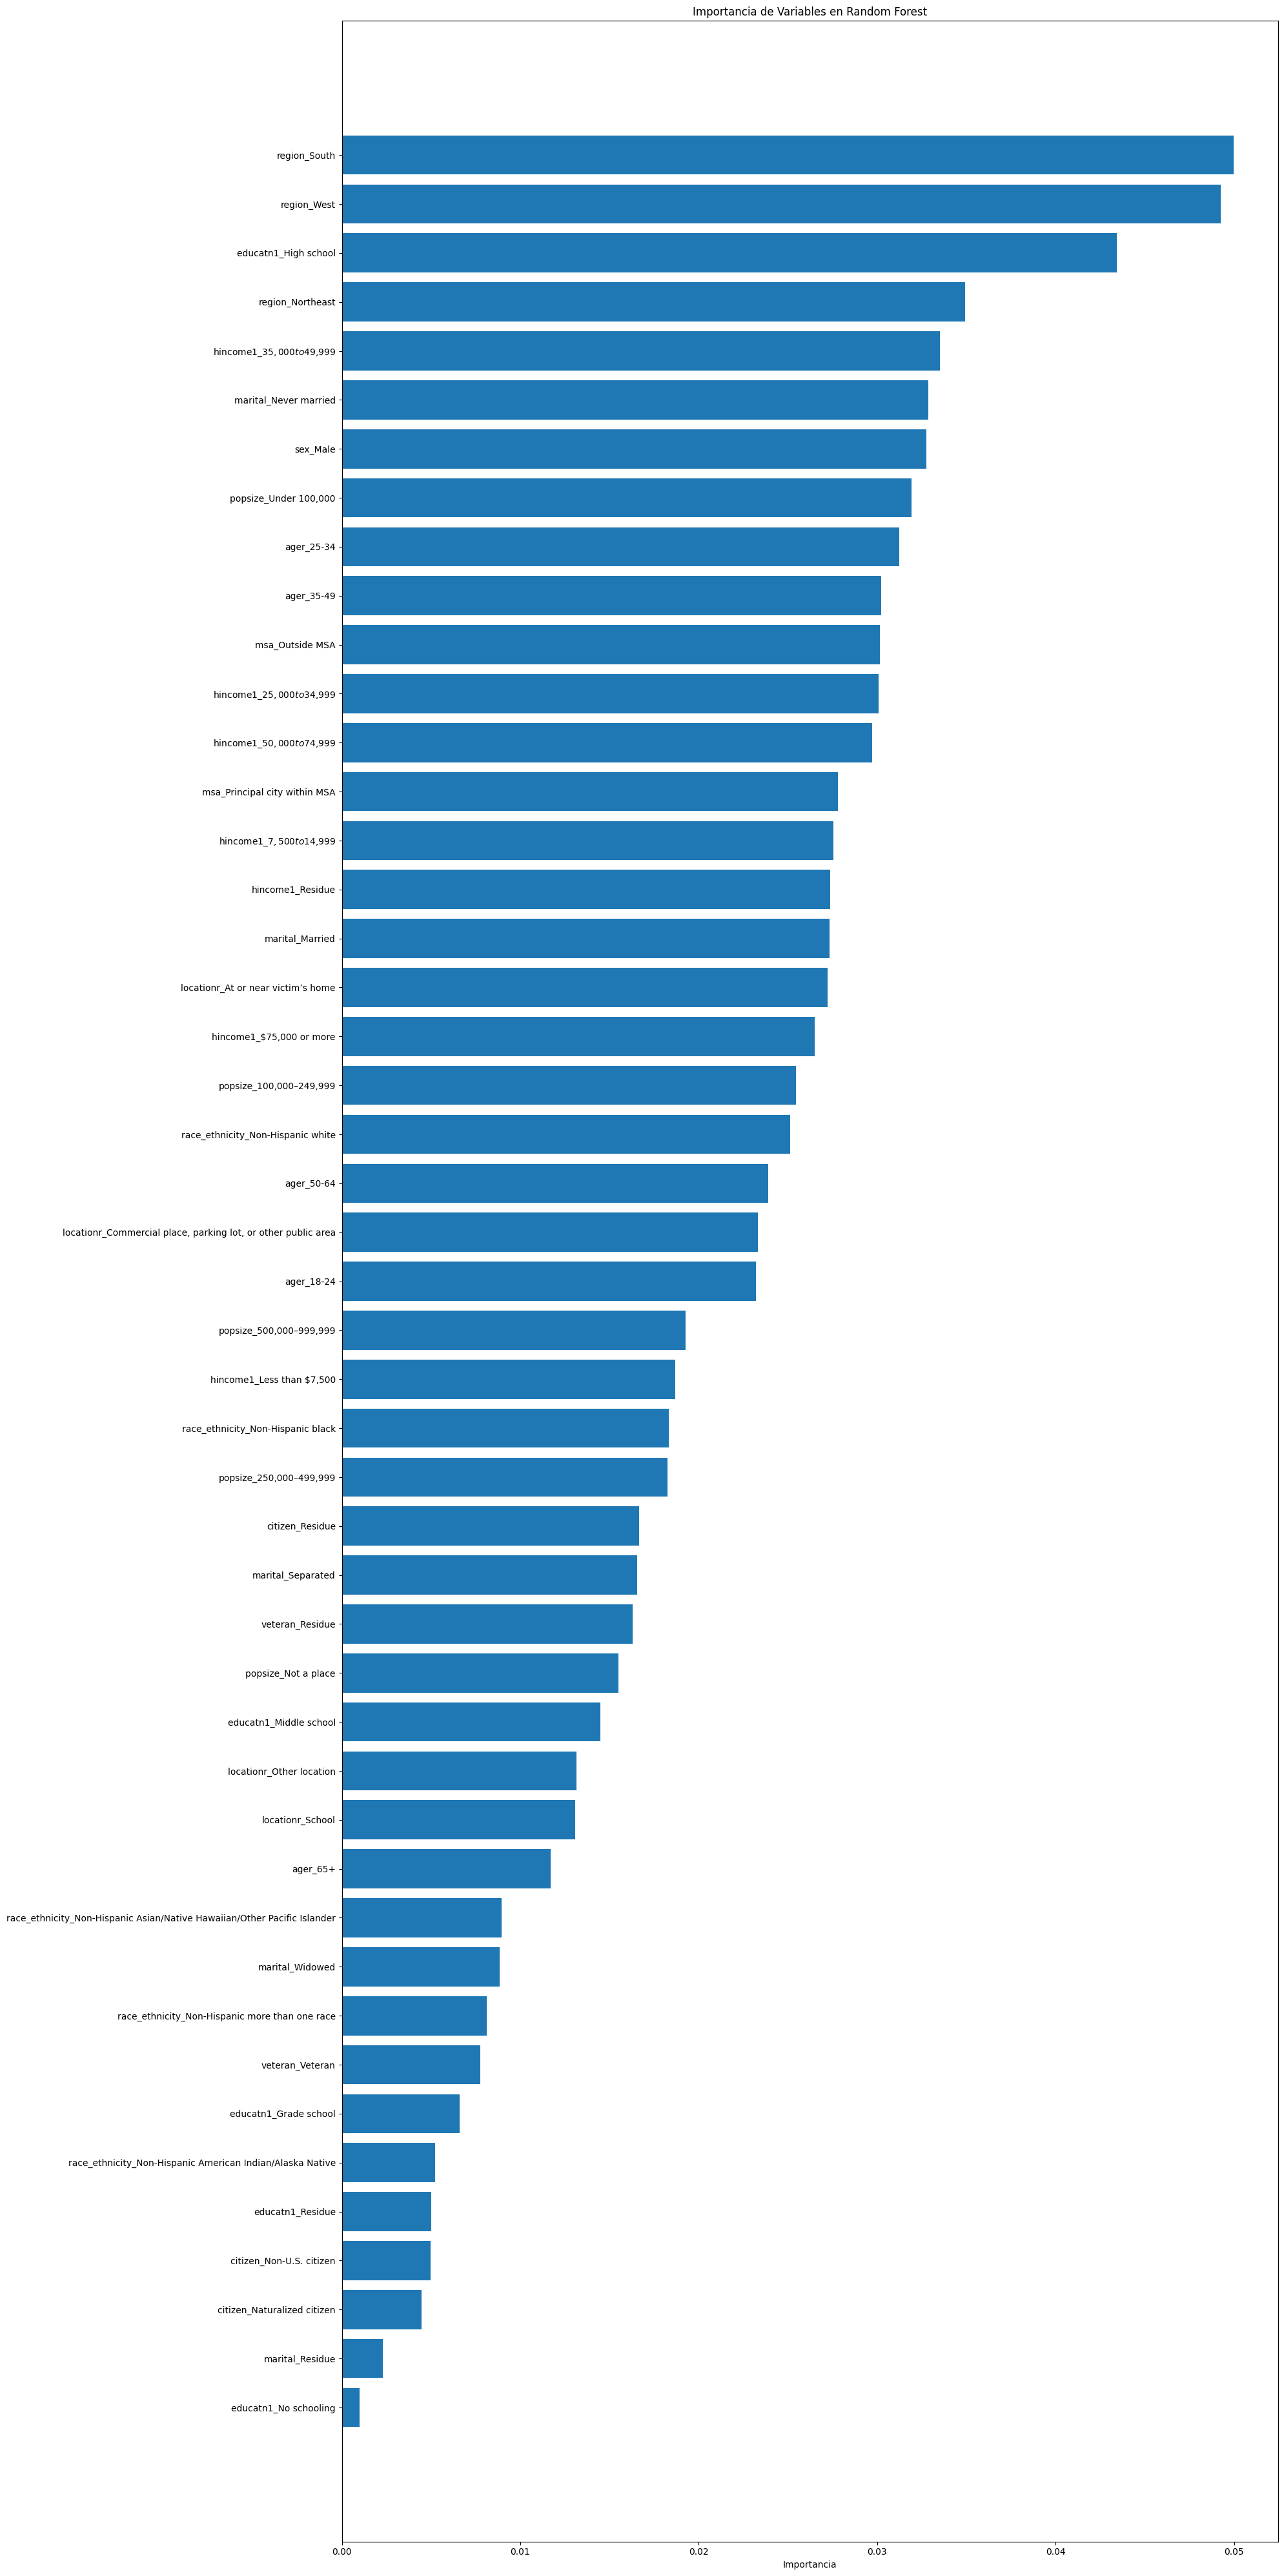

In [23]:
importances = base_line.feature_importances_
features = x_train.columns

# Crear DataFrame para visualizar
feature_importance_df = pd.DataFrame({
    'Variable': features,
    'Importancia': importances
}).sort_values('Importancia', ascending=False)

print("\n=== IMPORTANCIA DE VARIABLES ===")
print(feature_importance_df)

# Visualización
plt.figure(figsize=(20, 40))
plt.barh(feature_importance_df['Variable'], feature_importance_df['Importancia'])
plt.xlabel('Importancia')
plt.title('Importancia de Variables en Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [9]:
y_pred_rf  = base_line.predict(x_test)
y_proba_rf = base_line.predict_proba(x_test)[:, 1]

In [10]:
y_pred_train_rf  = base_line.predict(x_train)
y_proba_train_rf = base_line.predict_proba(x_train)[:, 1]

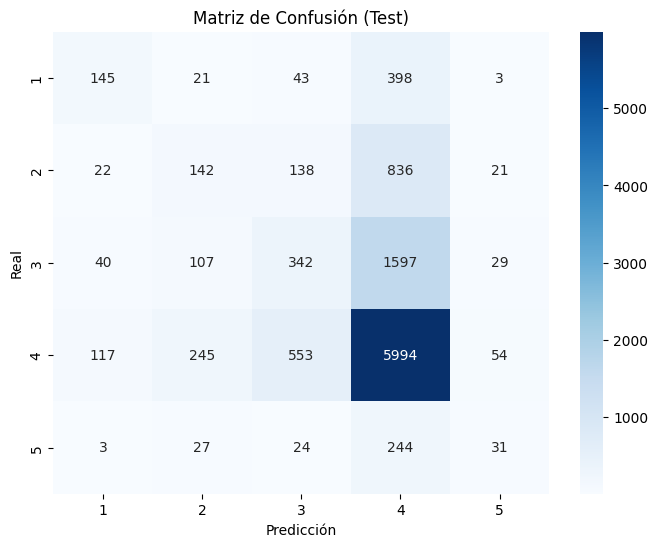

In [11]:
conf_matrix_val = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
plt.title("Matriz de Confusión (Test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

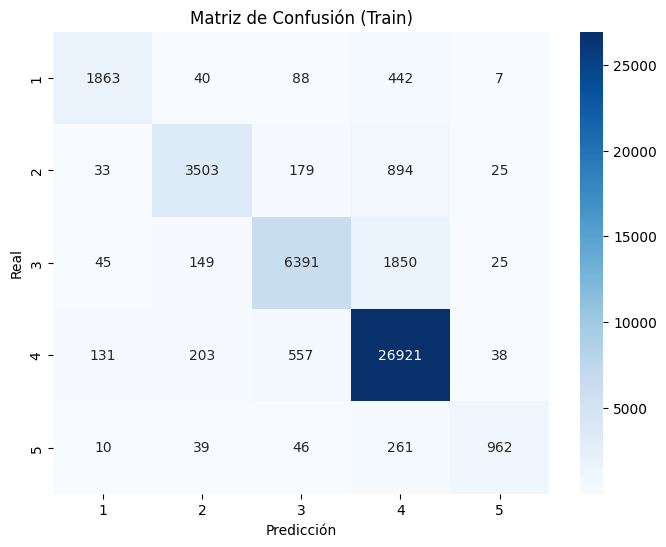

In [12]:
conf_matrix_val = confusion_matrix(y_train, y_pred_train_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
plt.title("Matriz de Confusión (Train)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

In [13]:
print("Report de Clasificación (test):")
print(classification_report(y_test, y_pred_rf))

Report de Clasificación (test):
              precision    recall  f1-score   support

           1       0.44      0.24      0.31       610
           2       0.26      0.12      0.17      1159
           3       0.31      0.16      0.21      2115
           4       0.66      0.86      0.75      6963
           5       0.22      0.09      0.13       329

    accuracy                           0.60     11176
   macro avg       0.38      0.30      0.31     11176
weighted avg       0.53      0.60      0.54     11176



In [14]:
print("Report de Clasificación (train):")
print(classification_report(y_train, y_pred_train_rf))

Report de Clasificación (train):
              precision    recall  f1-score   support

           1       0.89      0.76      0.82      2440
           2       0.89      0.76      0.82      4634
           3       0.88      0.76      0.81      8460
           4       0.89      0.97      0.92     27850
           5       0.91      0.73      0.81      1318

    accuracy                           0.89     44702
   macro avg       0.89      0.79      0.84     44702
weighted avg       0.89      0.89      0.88     44702



In [15]:
# .predict_proba() devuelve un array 2D (dimensión 2)
y_proba_train_rf = base_line.predict_proba(x_train)

# ¡CORRECTO! Ahora y_proba_rf tiene la forma (n_samples, n_classes)
auc_val_rf = roc_auc_score(
    y_train,
    y_proba_train_rf,
    multi_class='ovr',
    average='macro'
)

print(f"AUC (OvR, Macro): {auc_val_rf}")

AUC (OvR, Macro): 0.9875723944207315


In [16]:
# .predict_proba() devuelve un array 2D (dimensión 2)
y_proba_rf = base_line.predict_proba(x_test)

# ¡CORRECTO! Ahora y_proba_rf tiene la forma (n_samples, n_classes)
auc_val_rf = roc_auc_score(
    y_test,
    y_proba_rf,
    multi_class='ovr',
    average='macro'
)

print(f"AUC (OvR, Macro): {auc_val_rf}")

AUC (OvR, Macro): 0.6708965461308424


No se puede trazar una curva ROC de una multiclases sin antes binarizar todas las clases y para eso usamos label_binarize


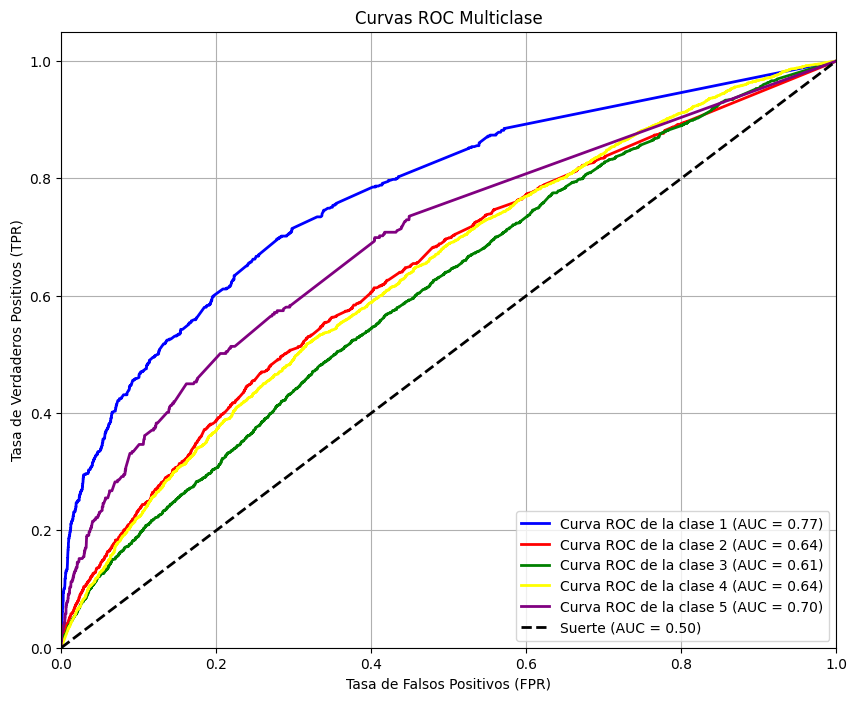

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# --- Tus datos ---
# y_test (tus etiquetas verdaderas, ej: [0, 1, 2, 3, 4, 1, 0, ...])
# y_proba_rf (salida de predict_proba(), forma: [n_samples, 5])
# y_proba_rf = base_line.predict_proba(x_test)


# --- 1. Definir el número de clases y sus etiquetas ---

n_classes = 5  # <-- ¡AJUSTAR AQUÍ!

# Ajusta esta lista para que coincida con tus etiquetas de clase reales.
# Puedes obtenerlas automáticamente con: base_line.classes_
classes = [1,2,3,4,5]  # <-- ¡AJUSTAR AQUÍ!
# O, si son strings: classes = ['clase_A', 'clase_B', 'clase_C', 'clase_D', 'clase_E']
# O, de forma robusta: classes = base_line.classes_

# --- 2. Binarizar y_test ---
y_test_binarized = label_binarize(y_test, classes=classes)

# --- 3. Calcular FPR, TPR y AUC para cada clase ---
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- 4. Trazar (Plot) todas las curvas ROC ---
plt.figure(figsize=(10, 8))

# El 'cycle' se encargará de repetir colores si hay más de 5 clases
colors = cycle(['blue', 'red', 'green', 'yellow', 'purple', 'aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Curva ROC de la clase {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Trazar la línea de "suerte" (chance)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Suerte (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC Multiclase')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

<H1>Crear un mejor modelo con GridSearch<H1>


Se crea un modelo con GridSearch para hacer una serie de combinaciones con muchos hiperparámtros que nos servirán luego para escoger el mejor de ellos.

In [97]:
grid_1 = param_grid_genrator(n_estimators = [50, 100, 150], max_depth= [6,10, 12], min_samples_split= [10, 20, 5], min_samples_leaf=[3, 8, 20])
modelo_1 = rf_crear_modelo(grid_1,"f1_macro",5)

In [102]:
inicio = time.time()
modelo_1.fit(x_train, y_train)
fin = time.time()
tiempo_entrenamiento = fin - inicio

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\Iabd\AppData\Local\anaconda3\envs\LibreriaTest1\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Iabd\AppData\Local\anaconda3\envs\LibreriaTest1\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [106]:
accuracy_train, accuracy_test, recall_train, recall_test, f1_score_train, f1_score_test = calcular_metricas(modelo_1, x_train,y_train,x_test,y_test)

TRAIN
Accuracy (train): 0.6230
Recall (train): 0.2000
F1-score (train): 0.1535
TEST
Accuracy (test): 0.6230
Recall (test): 0.2000
F1-score (test): 0.1535


In [108]:
best_params_1 = modelo_1.best_params_
print(f"Mejores Parámetros: {best_params_1}")

Mejores Parámetros: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 50}


In [109]:
best_model_1 = modelo_1.best_estimator_

In [110]:
y_pred_1  = best_model_1.predict(x_test)
y_proba_1 = best_model_1.predict_proba(x_test)[:, 1]

In [111]:
y_pred_train_1  = best_model_1.predict(x_train)
y_proba_train_1 = best_model_1.predict_proba(x_train)[:, 1]

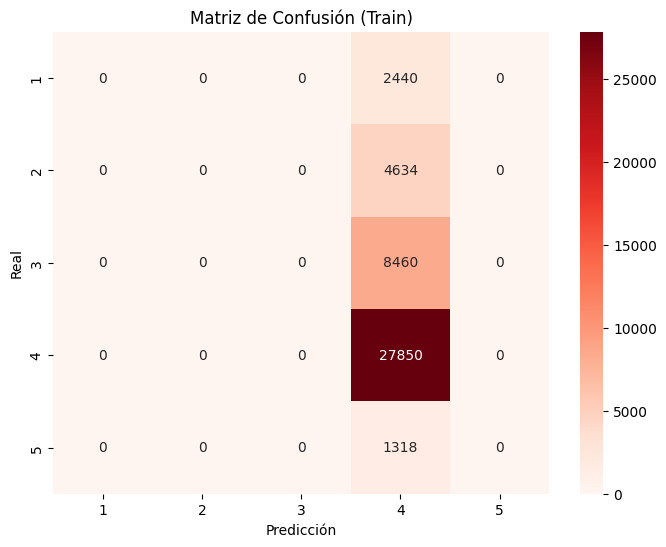

In [113]:
conf_matrix_val = confusion_matrix(y_train, y_pred_train_1)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Reds', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
plt.title("Matriz de Confusión (Train)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

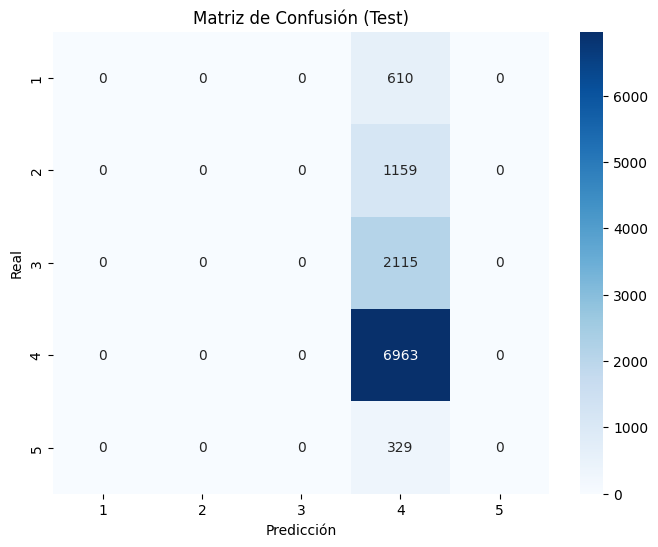

In [112]:
conf_matrix_val = confusion_matrix(y_test, y_pred_1)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
plt.title("Matriz de Confusión (Test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

In [114]:
print("Report de Clasificación (train):")
print(classification_report(y_train, y_pred_train_1))

Report de Clasificación (train):
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2440
           2       0.00      0.00      0.00      4634
           3       0.00      0.00      0.00      8460
           4       0.62      1.00      0.77     27850
           5       0.00      0.00      0.00      1318

    accuracy                           0.62     44702
   macro avg       0.12      0.20      0.15     44702
weighted avg       0.39      0.62      0.48     44702



c:\Users\Iabd\AppData\Local\anaconda3\envs\LibreriaTest1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Iabd\AppData\Local\anaconda3\envs\LibreriaTest1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Iabd\AppData\Local\anaconda3\envs\LibreriaTest1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [116]:
print("Report de Clasificación (test):")
print(classification_report(y_test, y_pred_1))

Report de Clasificación (test):
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       610
           2       0.00      0.00      0.00      1159
           3       0.00      0.00      0.00      2115
           4       0.62      1.00      0.77      6963
           5       0.00      0.00      0.00       329

    accuracy                           0.62     11176
   macro avg       0.12      0.20      0.15     11176
weighted avg       0.39      0.62      0.48     11176



c:\Users\Iabd\AppData\Local\anaconda3\envs\LibreriaTest1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Iabd\AppData\Local\anaconda3\envs\LibreriaTest1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Iabd\AppData\Local\anaconda3\envs\LibreriaTest1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [119]:
agregar_metrica(
    modelo="Random Forest",
    experimento="modelo 1",
    accuracy_train=accuracy_train,
    accuracy_test=accuracy_test,
    recall_train=recall_train,
    recall_test=recall_test,
    f1_train=f1_score_train,
    f1_test=f1_score_test,
    tiempo_entrenamiento_seg=tiempo_entrenamiento,
    overfitting="Sí" if accuracy_train - accuracy_test > 0.05 else "No",
    observaciones=f"Mejores parámetros: {best_params_1}"
)

Archivo metrics_random_forest.csv creado y métrica agregada.


<H1> Experimento 2 <H1>

<H3> Samplear modelo con Smote<H3>



In [123]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Si tienes un DataFrame
x_train_smote = pd.DataFrame(x_train)

# Convierte booleanos a enteros
for col in x_train_smote.select_dtypes('bool').columns:
    x_train_smote[col] = x_train_smote[col].astype(int)

# Convierte categóricas (object) a números
le = LabelEncoder()
for col in x_train_smote.select_dtypes('object').columns:
    x_train_smote[col] = le.fit_transform(x_train_smote[col])


In [124]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(x_train_smote, y_train)


In [126]:

gird_2 = param_grid_genrator([50, 100, 150],[6,10, 12], [10, 20, 5], [3, 8, 20])
modelo_2 = rf_crear_modelo(gird_2,"f1_macro",5)

In [127]:
inicio = time.time()
modelo_2.fit(x_res, y_res)
fin = time.time()
tiempo_entrenamiento_2 = fin - inicio

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\Iabd\AppData\Local\anaconda3\envs\LibreriaTest1\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\Iabd\AppData\Local\anaconda3\envs\LibreriaTest1\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [170]:
accuracy_train, accuracy_test, recall_train, recall_test, f1_score_train, f1_score_test = calcular_metricas(modelo_2, x_res,y_res,x_test,y_test)

TRAIN
Accuracy (train): 0.4479
Recall (train): 0.4479
F1-score (train): 0.4250
TEST
Accuracy (test): 0.3315
Recall (test): 0.3877
F1-score (test): 0.2589


In [129]:
best_params_2 = modelo_2.best_params_
print(f"Mejores valores encontrados {best_params_2}")

Mejores valores encontrados {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 50}


Almacenamos el mejor modelo de los mejores parámetros.

In [130]:
best_model_2 = modelo_2.best_estimator_

In [131]:
best_scoring_2 = modelo_2.best_score_
print(f"Mejor scoring obtenido: {best_scoring_2}")

Mejor scoring obtenido: nan


In [132]:
y_pred_2  = best_model_2.predict(x_test)
y_proba_2 = best_model_2.predict_proba(x_test)[:, 1]

In [133]:
y_pred_train_2  = best_model_2.predict(x_res)
y_proba_train_2 = best_model_2.predict_proba(x_res)[:, 1]

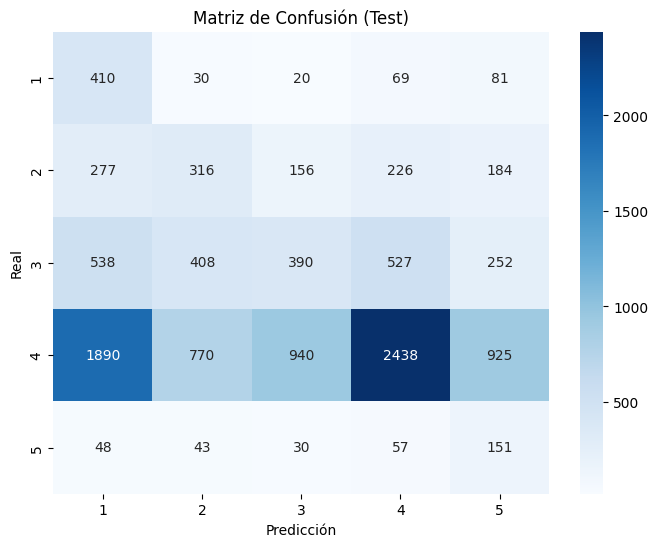

In [134]:
conf_matrix_val = confusion_matrix(y_test, y_pred_2)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
plt.title("Matriz de Confusión (Test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

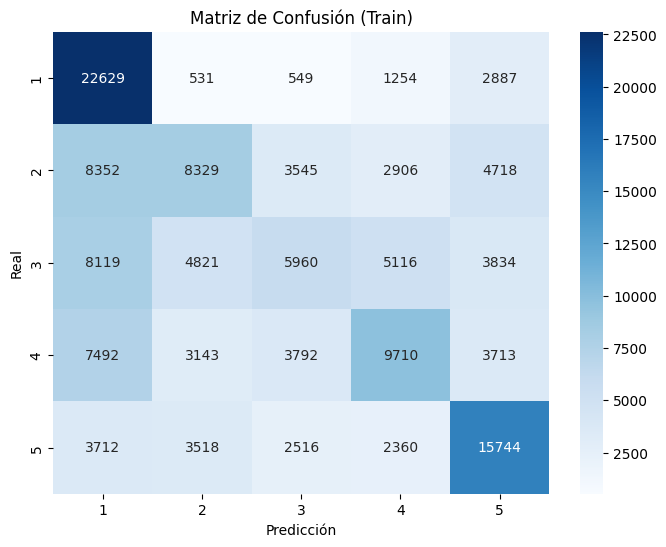

In [135]:
conf_matrix_val = confusion_matrix(y_res, y_pred_train_2)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
plt.title("Matriz de Confusión (Train)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

In [136]:
print("Report de Clasificación (test):")
print(classification_report(y_test, y_pred_2))

Report de Clasificación (test):
              precision    recall  f1-score   support

           1       0.13      0.67      0.22       610
           2       0.20      0.27      0.23      1159
           3       0.25      0.18      0.21      2115
           4       0.74      0.35      0.47      6963
           5       0.09      0.46      0.16       329

    accuracy                           0.33     11176
   macro avg       0.28      0.39      0.26     11176
weighted avg       0.54      0.33      0.38     11176



In [137]:
print("Report de Clasificación (train):")
print(classification_report(y_res, y_pred_train_2))

Report de Clasificación (train):
              precision    recall  f1-score   support

           1       0.45      0.81      0.58     27850
           2       0.41      0.30      0.35     27850
           3       0.36      0.21      0.27     27850
           4       0.45      0.35      0.39     27850
           5       0.51      0.57      0.54     27850

    accuracy                           0.45    139250
   macro avg       0.44      0.45      0.43    139250
weighted avg       0.44      0.45      0.43    139250



In [171]:
agregar_metrica(
    modelo="Random Forest",
    experimento="modelo 2",
    accuracy_train=accuracy_train,
    accuracy_test=accuracy_test,
    recall_train=recall_train,
    recall_test=recall_test,
    f1_train=f1_score_train,
    f1_test=f1_score_test,
    tiempo_entrenamiento_seg=tiempo_entrenamiento_2,
    overfitting="Sí" if accuracy_train - accuracy_test > 0.05 else "No",
    observaciones=f"Mejores parámetros: {best_params_2}"
)

Archivo metrics_random_forest.csv creado y métrica agregada.


<h3> CREAR BALANCEADO CON CLASS_WEIGHT Y ACCURACY_BALANCED

In [147]:
grid_3 = param_grid_genrator([50, 100, 150],[3, 6 , 10],[3, 5, 10], [3, 8, 10])

In [148]:
modelo_3 = GridSearchCV(
            estimator = RandomForestClassifier(random_state=42, n_jobs= -1, class_weight='balanced'),
            param_grid=grid_3,
            scoring="balanced_accuracy",
            cv = 5,
            n_jobs=-1,
            verbose= 1
        )

In [149]:
inicio = time.time()
modelo_3.fit(x_res, y_res)
fin = time.time()
tiempo_entrenamiento_3 = fin - inicio

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\Iabd\AppData\Local\anaconda3\envs\LibreriaTest1\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [173]:
accuracy_train, accuracy_test, recall_train, recall_test, f1_score_train, f1_score_test = calcular_metricas(modelo_3, x_res,y_res,x_test,y_test)

TRAIN
Accuracy (train): 0.5129
Recall (train): 0.5129
F1-score (train): 0.4977
TEST
Accuracy (test): 0.3612
Recall (test): 0.3941
F1-score (test): 0.2760


In [151]:
best_model_3 = modelo_3.best_estimator_

In [153]:
best_socring_3 = modelo_3.best_score_
print(f"Mejor scoring obtenido: {best_socring_3}")

Mejor scoring obtenido: 0.49747935368043084


In [154]:
best_params_3 = modelo_3.best_params_
print(f"Mejores valores encontrados {best_params_3}")

Mejores valores encontrados {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 150}


In [155]:
y_pred_3  = best_model_3.predict(x_test)
y_proba_3 = best_model_3.predict_proba(x_test)[:, 1]

In [156]:
y_pred_train_3  = best_model_3.predict(x_res)
y_proba_train_3 = best_model_3.predict_proba(x_res)[:, 1]

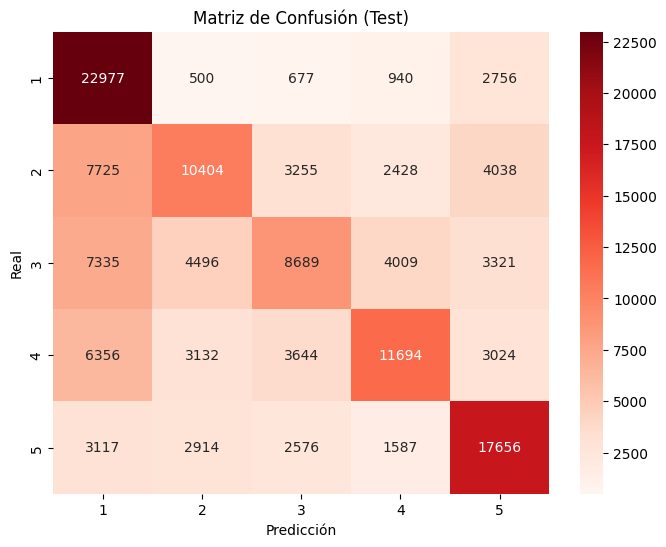

In [158]:
conf_matrix_val = confusion_matrix(y_res, y_pred_train_3)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Reds', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
plt.title("Matriz de Confusión (Test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

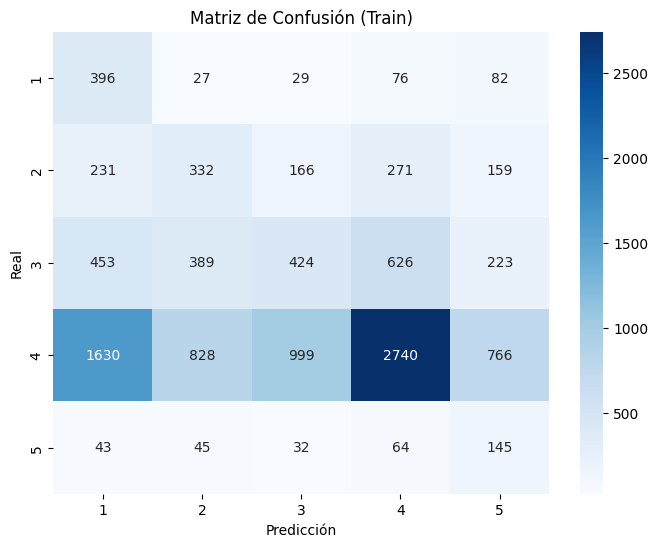

In [159]:
conf_matrix_val = confusion_matrix(y_test, y_pred_3)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
plt.title("Matriz de Confusión (Train)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

In [162]:
print("Report de Clasificación (train):")
print(classification_report(y_res, y_pred_train_3))

Report de Clasificación (train):
              precision    recall  f1-score   support

           1       0.48      0.83      0.61     27850
           2       0.49      0.37      0.42     27850
           3       0.46      0.31      0.37     27850
           4       0.57      0.42      0.48     27850
           5       0.57      0.63      0.60     27850

    accuracy                           0.51    139250
   macro avg       0.51      0.51      0.50    139250
weighted avg       0.51      0.51      0.50    139250



In [163]:
print("Report de Clasificación (test):")
print(classification_report(y_test, y_pred_2))

Report de Clasificación (test):
              precision    recall  f1-score   support

           1       0.13      0.67      0.22       610
           2       0.20      0.27      0.23      1159
           3       0.25      0.18      0.21      2115
           4       0.74      0.35      0.47      6963
           5       0.09      0.46      0.16       329

    accuracy                           0.33     11176
   macro avg       0.28      0.39      0.26     11176
weighted avg       0.54      0.33      0.38     11176



<h3>Función guardar métricas.<h3>

In [174]:
agregar_metrica(
    modelo="Random Forest",
    experimento="modelo 3",
    accuracy_train=accuracy_train,
    accuracy_test=accuracy_test,
    recall_train=recall_train,
    recall_test=recall_test,
    f1_train=f1_score_train,
    f1_test=f1_score_test,
    tiempo_entrenamiento_seg=tiempo_entrenamiento_3,
    overfitting="Sí" if accuracy_train - accuracy_test > 0.05 else "No",
    observaciones=f"Mejores parámetros: {best_params_3}"
)

Métrica agregada correctamente a metrics_random_forest.csv.


In [175]:
df = pd.read_csv(ARCHIVO_METRICAS)
df

,modelo,experimento,accuracy_train,accuracy_test,recall_train_avg,recall_test_avg,f1_train_avg,f1_test_avg,tiempo_entrenamiento_seg,overfitting,observaciones
0,Random Forest,modelo 2,0.447914,0.331514,0.447914,0.387656,0.425021,0.258852,838.923024,Sí,"Mejores parámetros: {'criterion': 'gini', 'max..."
1,Random Forest,modelo 3,0.512890,0.361220,0.512890,0.394069,0.497673,0.276003,649.121106,Sí,"Mejores parámetros: {'criterion': 'gini', 'max..."
